AIN311 CLASS PROJECT

MELİKE NUR DULKADİR & SARE NAZ ERSOY

# Career Path Predictor

Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import tree,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Umang-19/devjam/main/public/mldata.csv')
df.head()

,Logical quotient rating,hackathons,coding skills rating,public speaking points,self-learning capability?,Extra-courses did,certifications,workshops,reading and writing skills,memory capability score,Interested subjects,interested career area,Type of company want to settle in?,Taken inputs from seniors or elders,Interested Type of Books,Management or Technical,hard/smart worker,worked in teams ever?,Introvert,Suggested Job Role
0,5,0,6,2,yes,no,information security,testing,poor,poor,programming,testing,BPA,no,Series,Management,smart worker,yes,no,Applications Developer
1,7,6,4,3,no,yes,shell programming,testing,excellent,medium,Management,system developer,Cloud Services,yes,Autobiographies,Technical,hard worker,no,yes,Applications Developer
2,2,3,9,1,no,yes,information security,testing,excellent,poor,data engineering,Business process analyst,product development,yes,Travel,Technical,smart worker,no,no,Applications Developer
3,2,6,3,5,no,yes,r programming,database security,excellent,poor,networks,testing,Testing and Maintainance Services,yes,Guide,Management,smart worker,yes,yes,Applications Developer
4,2,0,3,4,yes,no,distro making,game development,excellent,medium,Software Engineering,system developer,BPA,no,Health,Technical,hard worker,yes,no,Applications Developer


In [3]:
df.columns

Index(['Logical quotient rating', 'hackathons', 'coding skills rating',
       'public speaking points', 'self-learning capability?',
       'Extra-courses did', 'certifications', 'workshops',
       'reading and writing skills', 'memory capability score',
       'Interested subjects', 'interested career area ',
       'Type of company want to settle in?',
       'Taken inputs from seniors or elders', 'Interested Type of Books',
       'Management or Technical', 'hard/smart worker', 'worked in teams ever?',
       'Introvert', 'Suggested Job Role'],
      dtype='object')

Some utils functions for understand the data clearly

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Properties #####################")
    print(df.describe())

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    #num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th anddataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    #cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    #num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
   # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [6]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [7]:
def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [8]:
def check_outlier(dataframe, col_name, q1=.25, q3=.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [9]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [10]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [11]:
check_df(df)

##################### Shape #####################
(6901, 20)
##################### Types #####################
Logical quotient rating                 int64
hackathons                              int64
coding skills rating                    int64
public speaking points                  int64
self-learning capability?              object
Extra-courses did                      object
certifications                         object
workshops                              object
reading and writing skills             object
memory capability score                object
Interested subjects                    object
interested career area                 object
Type of company want to settle in?     object
Taken inputs from seniors or elders    object
Interested Type of Books               object
Management or Technical                object
hard/smart worker                      object
worked in teams ever?                  object
Introvert                              object
Suggested Job R

In [12]:
df.columns = ['Logical_Quotient_Rating', 'Hackathons', 'Coding_Skills_Rating',
              'Public_Speaking_Points', 'Self_Learning_Capability',
              'Extra_Courses_Did', 'Certifications', 'Workshops',
              'Reading_And_Writing_Skills', 'Memory_Capability_Score',
              'Interested_Subjects', 'Interested_Career_Area',
              'Type_Of_Company_Want_To_Settle_In',
              'Taken_Inputs_From_Seniors_Or-Elders', 'Interested_Type_Of_Books',
              'Management_Or_Technical', 'Working_Type', 'Worked_In_Teams_Ever',
              'Introvert', 'Suggested_Job_Role']

In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 6901
Variables: 20
cat_cols: 15
num_cols: 4
cat_but_car: 1


In [14]:
num_cols

['Logical_Quotient_Rating',
 'Hackathons',
 'Coding_Skills_Rating',
 'Public_Speaking_Points']

In [15]:
for col in num_cols:
    print(check_outlier(df,col))

False
False
False
False


<AxesSubplot: >

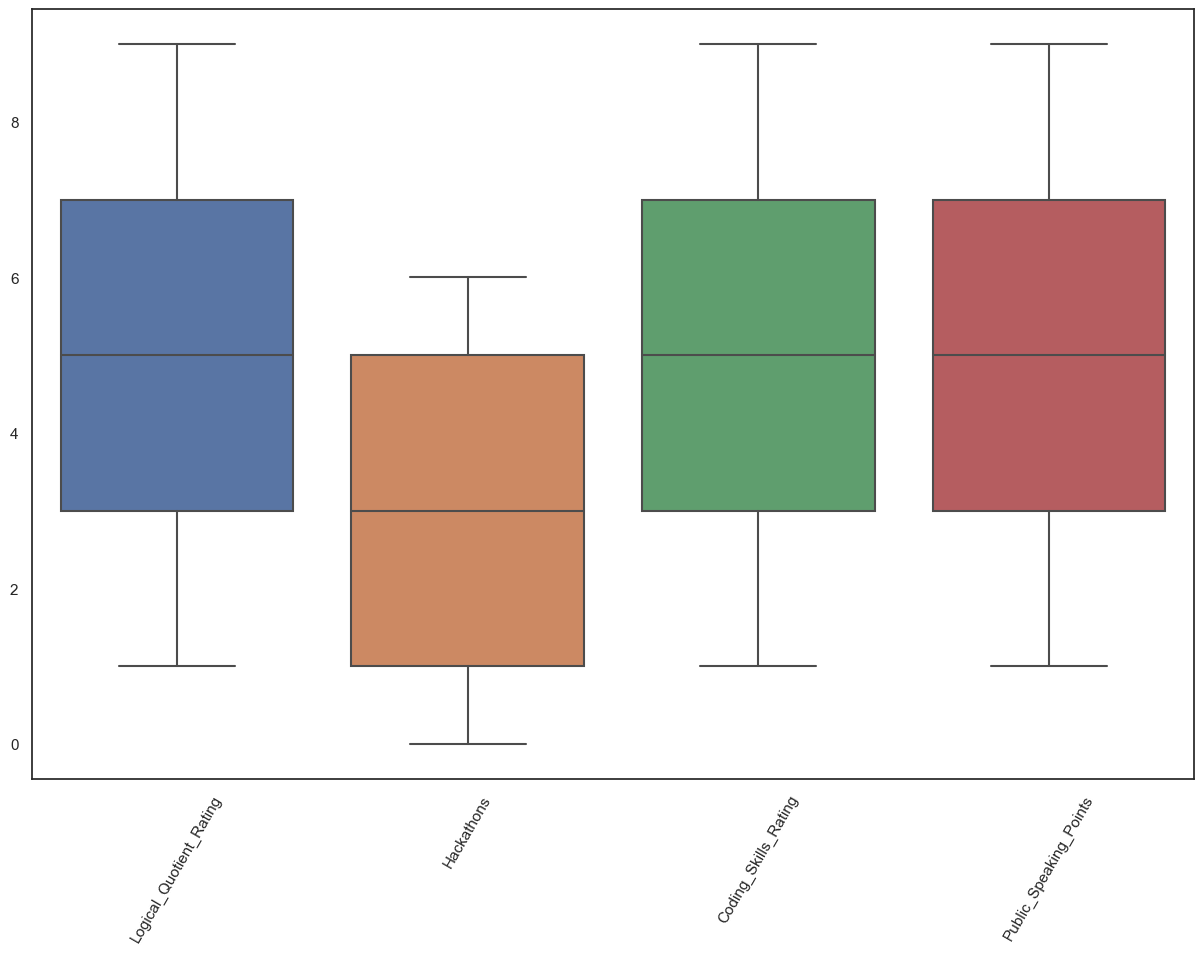

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df[num_cols], ax=ax)

In [17]:
print("\n######## List of Categorical features ########\n")
for index,col in enumerate(cat_cols):
    print(index,col)


######## List of Categorical features ########

0 Self_Learning_Capability
1 Extra_Courses_Did
2 Certifications
3 Workshops
4 Reading_And_Writing_Skills
5 Memory_Capability_Score
6 Interested_Subjects
7 Interested_Career_Area
8 Type_Of_Company_Want_To_Settle_In
9 Taken_Inputs_From_Seniors_Or-Elders
10 Management_Or_Technical
11 Working_Type
12 Worked_In_Teams_Ever
13 Introvert
14 Suggested_Job_Role


In [18]:
for i in cat_cols:
    print(df[i].value_counts(), end="\n\n")

yes    3496
no     3405
Name: Self_Learning_Capability, dtype: int64

no     3529
yes    3372
Name: Extra_Courses_Did, dtype: int64

r programming           803
information security    785
shell programming       783
machine learning        783
full stack              768
hadoop                  764
python                  756
distro making           740
app development         719
Name: Certifications, dtype: int64

database security    897
system designing     891
web technologies     891
hacking              867
testing              852
data science         842
game development     831
cloud computing      830
Name: Workshops, dtype: int64

excellent    2328
medium       2315
poor         2258
Name: Reading_And_Writing_Skills, dtype: int64

medium       2317
excellent    2303
poor         2281
Name: Memory_Capability_Score, dtype: int64

Software Engineering     731
IOT                      722
cloud computing          721
programming              716
networks                 713
Co

In [19]:
cat_cols

['Self_Learning_Capability',
 'Extra_Courses_Did',
 'Certifications',
 'Workshops',
 'Reading_And_Writing_Skills',
 'Memory_Capability_Score',
 'Interested_Subjects',
 'Interested_Career_Area',
 'Type_Of_Company_Want_To_Settle_In',
 'Taken_Inputs_From_Seniors_Or-Elders',
 'Management_Or_Technical',
 'Working_Type',
 'Worked_In_Teams_Ever',
 'Introvert',
 'Suggested_Job_Role']

<AxesSubplot: >

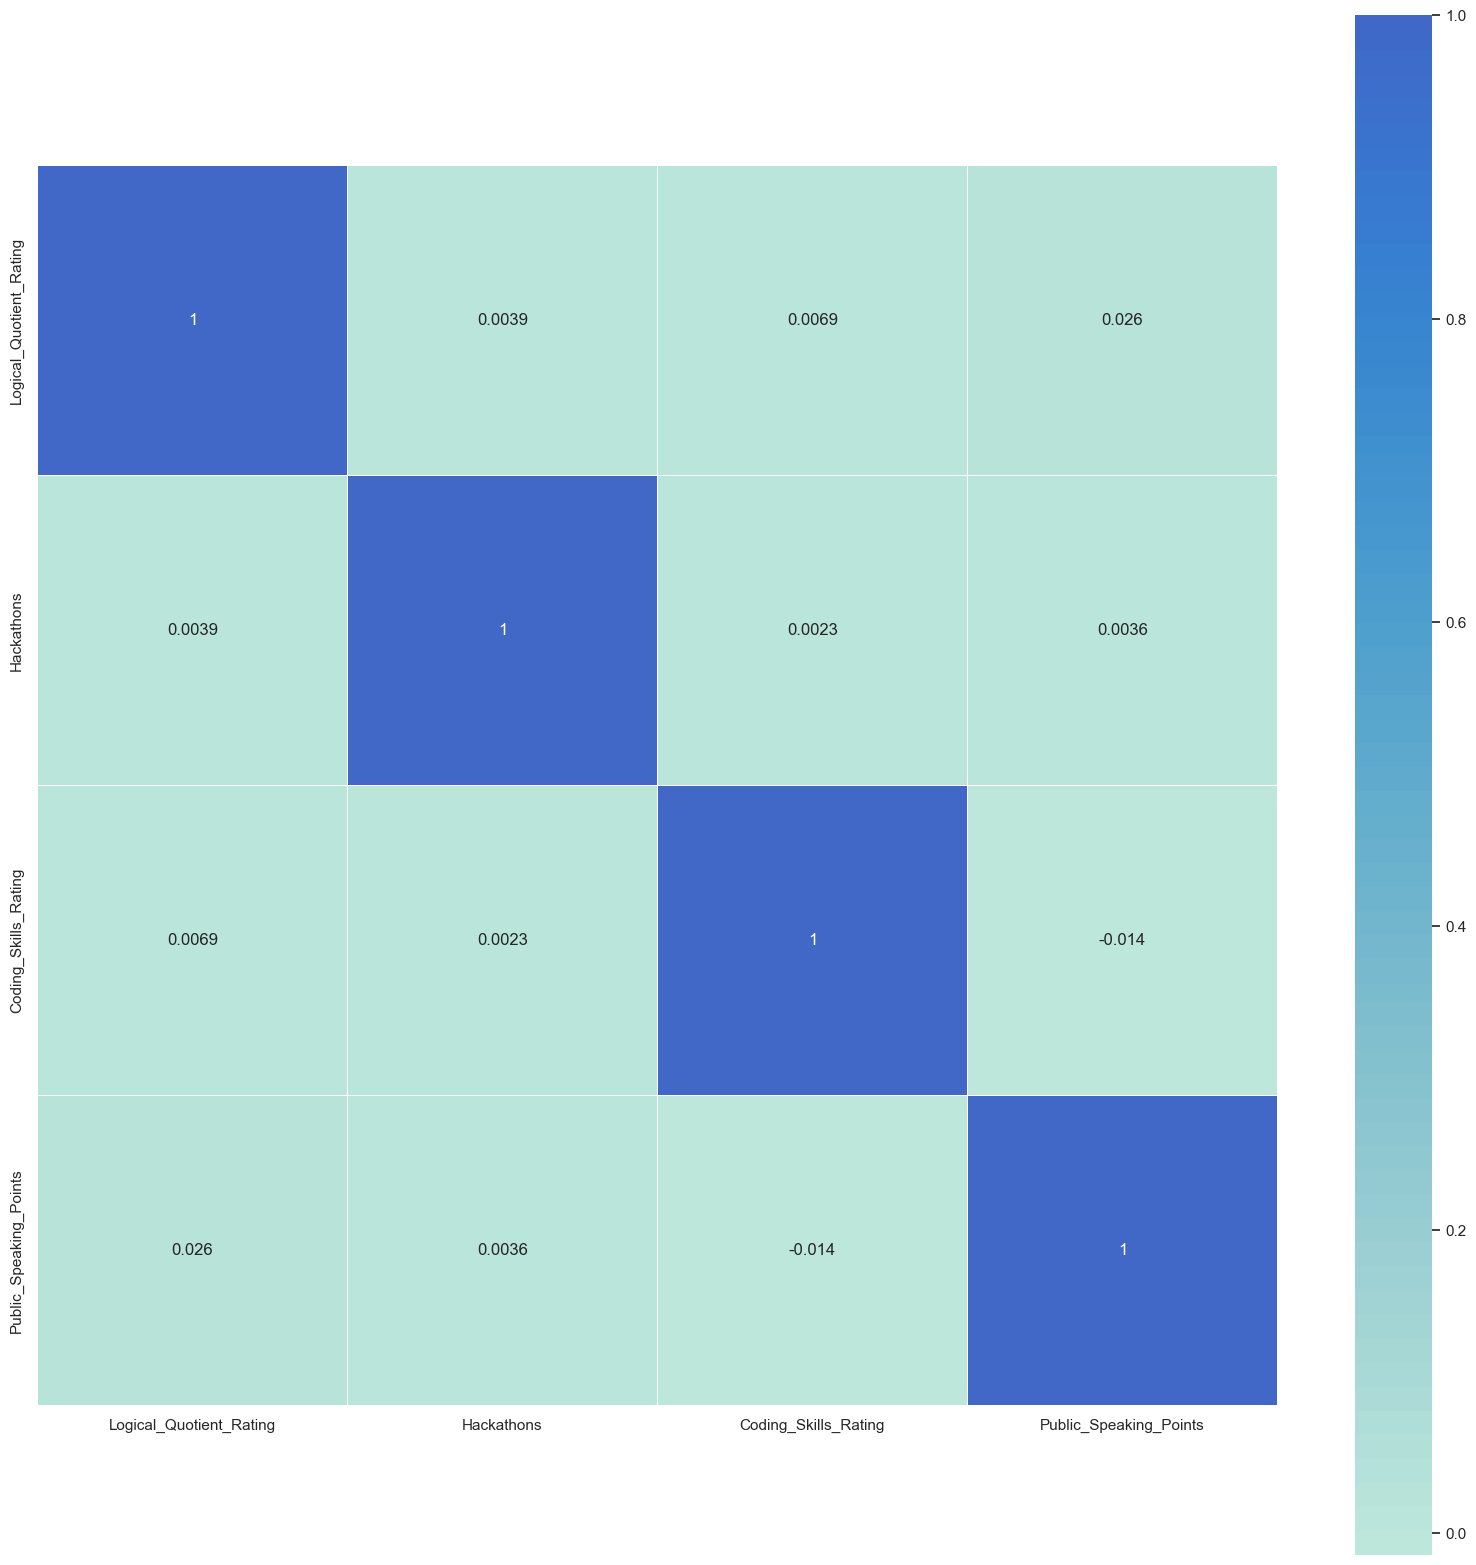

In [20]:
df3 = df.drop(columns = ["Suggested_Job_Role"])
df3 = df3.corr()
f,axes = plt.subplots(1,1,figsize = (20,20))
sns.heatmap(df3,square=True,annot = True,linewidth = .4,center = 2,ax = axes)

In [21]:
pca = PCA()
pca.fit(df3)
PC_components = np.arange(pca.n_components_) + 1

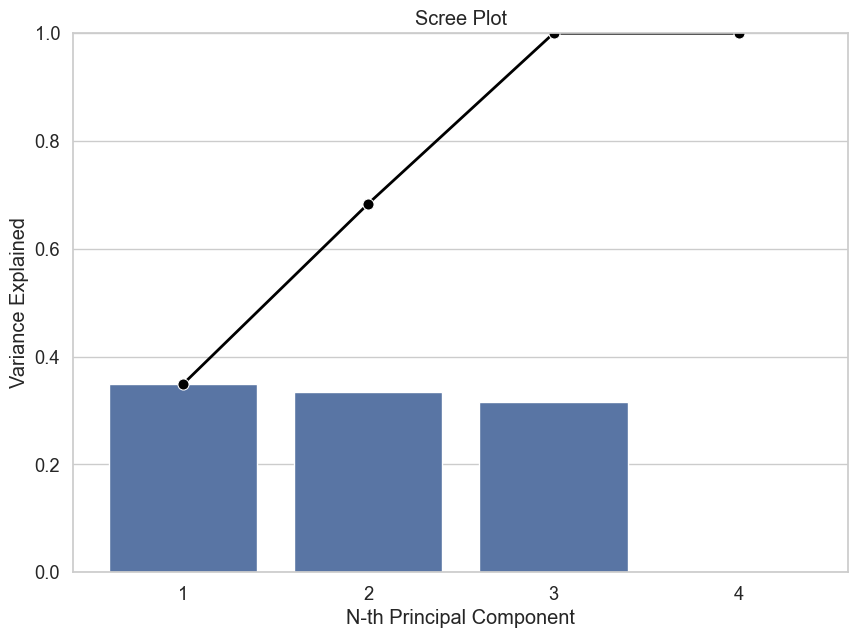

In [22]:
# Scree Plot
scree_plot = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 7))
scree_plot = sns.barplot(x=PC_components, y=pca.explained_variance_ratio_, color='b')
scree_plot = sns.lineplot(x=PC_components-1, y=np.cumsum(pca.explained_variance_ratio_), color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()
#As you see after 18 feature relation, there is no change in data explainability.
#Which means we can use 18 feature to explain our data.

In [23]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

In [24]:
drop_list = high_correlated_cols(df)

In [25]:
drop_list

[]

In [26]:
dummy_cols = ['Interested_Subjects',
              'Interested_Career_Area',
              'Type_Of_Company_Want_To_Settle_In',
              'Working_Type','Certifications',
              'Workshops']
dummy_cols

['Interested_Subjects',
 'Interested_Career_Area',
 'Type_Of_Company_Want_To_Settle_In',
 'Working_Type',
 'Certifications',
 'Workshops']

In [27]:
df.head()

,Logical_Quotient_Rating,Hackathons,Coding_Skills_Rating,Public_Speaking_Points,Self_Learning_Capability,Extra_Courses_Did,Certifications,Workshops,Reading_And_Writing_Skills,Memory_Capability_Score,Interested_Subjects,Interested_Career_Area,Type_Of_Company_Want_To_Settle_In,Taken_Inputs_From_Seniors_Or-Elders,Interested_Type_Of_Books,Management_Or_Technical,Working_Type,Worked_In_Teams_Ever,Introvert,Suggested_Job_Role
0,5,0,6,2,yes,no,information security,testing,poor,poor,programming,testing,BPA,no,Series,Management,smart worker,yes,no,Applications Developer
1,7,6,4,3,no,yes,shell programming,testing,excellent,medium,Management,system developer,Cloud Services,yes,Autobiographies,Technical,hard worker,no,yes,Applications Developer
2,2,3,9,1,no,yes,information security,testing,excellent,poor,data engineering,Business process analyst,product development,yes,Travel,Technical,smart worker,no,no,Applications Developer
3,2,6,3,5,no,yes,r programming,database security,excellent,poor,networks,testing,Testing and Maintainance Services,yes,Guide,Management,smart worker,yes,yes,Applications Developer
4,2,0,3,4,yes,no,distro making,game development,excellent,medium,Software Engineering,system developer,BPA,no,Health,Technical,hard worker,yes,no,Applications Developer


In [28]:
cat_cols.remove("Suggested_Job_Role")
label_encoder = LabelEncoder()
for cat_col in cat_cols:
    if cat_col not in dummy_cols:
        df[cat_col]= label_encoder.fit_transform(df[cat_col])

In [29]:
df2 = df[dummy_cols]

In [30]:
df2

,Interested_Subjects,Interested_Career_Area,Type_Of_Company_Want_To_Settle_In,Working_Type,Certifications,Workshops
0,programming,testing,BPA,smart worker,information security,testing
1,Management,system developer,Cloud Services,hard worker,shell programming,testing
2,data engineering,Business process analyst,product development,smart worker,information security,testing
3,networks,testing,Testing and Maintainance Services,smart worker,r programming,database security
4,Software Engineering,system developer,BPA,hard worker,distro making,game development
...,...,...,...,...,...,...
6896,Software Engineering,testing,Testing and Maintainance Services,smart worker,shell programming,hacking
6897,programming,testing,Testing and Maintainance Services,hard worker,machine learning,hacking
6898,IOT,system developer,Cloud Services,hard worker,distro making,data science
6899,data engineering,developer,SAaS services,smart worker,app development,game development


In [31]:
df2 = pd.get_dummies(df2,prefix="dum",drop_first=False)

In [32]:
df = df.join(df2)

In [33]:
df.drop(columns=dummy_cols, inplace=True)

In [34]:
df.head()

,Logical_Quotient_Rating,Hackathons,Coding_Skills_Rating,Public_Speaking_Points,Self_Learning_Capability,Extra_Courses_Did,Reading_And_Writing_Skills,Memory_Capability_Score,Taken_Inputs_From_Seniors_Or-Elders,Interested_Type_Of_Books,...,dum_r programming,dum_shell programming,dum_cloud computing,dum_data science,dum_database security,dum_game development,dum_hacking,dum_system designing,dum_testing,dum_web technologies
0,5,0,6,2,1,0,2,2,0,Series,...,0,0,0,0,0,0,0,0,1,0
1,7,6,4,3,0,1,0,1,1,Autobiographies,...,0,1,0,0,0,0,0,0,1,0
2,2,3,9,1,0,1,0,2,1,Travel,...,0,0,0,0,0,0,0,0,1,0
3,2,6,3,5,0,1,0,2,1,Guide,...,1,0,0,0,1,0,0,0,0,0
4,2,0,3,4,1,0,0,1,0,Health,...,0,0,0,0,0,1,0,0,0,0


As you see, with specific 7 columns,we obtained nothing. So, we decided to find and drop them.

In [35]:
df.drop(columns=drop_list, axis = 1, inplace=True)

We thought that the interested type of book is unnecessary and decided to drop that as well.

In [36]:
df.drop(columns=['Interested_Type_Of_Books'], inplace=True)

In [37]:
df.corr()

,Logical_Quotient_Rating,Hackathons,Coding_Skills_Rating,Public_Speaking_Points,Self_Learning_Capability,Extra_Courses_Did,Reading_And_Writing_Skills,Memory_Capability_Score,Taken_Inputs_From_Seniors_Or-Elders,Management_Or_Technical,...,dum_r programming,dum_shell programming,dum_cloud computing,dum_data science,dum_database security,dum_game development,dum_hacking,dum_system designing,dum_testing,dum_web technologies
Logical_Quotient_Rating,1.000000,0.003859,0.006866,0.025571,0.002745,-0.005253,-0.001423,-0.004152,-0.021540,-0.009456,...,0.000914,0.017555,-0.024636,0.011605,-0.001996,0.013555,-0.002580,0.003689,-0.005015,0.005198
Hackathons,0.003859,1.000000,0.002331,0.003577,0.002453,0.016294,0.003447,-0.006104,-0.001296,-0.008796,...,0.022760,-0.004040,0.002270,-0.012501,0.004986,0.004484,0.014845,0.000056,-0.016382,0.001990
Coding_Skills_Rating,0.006866,0.002331,1.000000,-0.014178,-0.012469,0.024928,0.007459,-0.005314,-0.000061,0.001705,...,-0.022631,-0.009500,0.009037,0.010856,-0.007822,-0.013161,-0.013840,-0.011367,0.003236,0.023128
Public_Speaking_Points,0.025571,0.003577,-0.014178,1.000000,-0.013377,-0.010865,-0.007169,-0.000496,-0.006792,-0.003080,...,0.005985,-0.018423,-0.002786,0.000150,-0.006709,0.015888,0.004739,0.002071,0.012032,-0.024695
Self_Learning_Capability,0.002745,0.002453,-0.012469,-0.013377,1.000000,0.006823,0.011542,-0.008128,-0.001497,0.009460,...,-0.003430,-0.001519,-0.028043,-0.017314,0.003952,0.013377,0.025171,-0.015882,0.006504,0.011777
Extra_Courses_Did,-0.005253,0.016294,0.024928,-0.010865,0.006823,1.000000,0.007896,0.005246,0.007146,0.005294,...,0.000573,0.000372,-0.000498,0.010255,0.008365,-0.004496,0.003815,-0.021928,-0.000272,0.004872
Reading_And_Writing_Skills,-0.001423,0.003447,0.007459,-0.007169,0.011542,0.007896,1.000000,-0.000485,0.029695,0.004584,...,-0.004355,-0.014606,0.008427,-0.001336,0.001638,0.010613,0.005790,-0.003161,-0.000193,-0.021186
Memory_Capability_Score,-0.004152,-0.006104,-0.005314,-0.000496,-0.008128,0.005246,-0.000485,1.000000,0.001480,-0.010680,...,0.000310,0.008687,0.008005,0.003088,-0.003247,-0.026415,0.009529,0.015822,0.004170,-0.011219
Taken_Inputs_From_Seniors_Or-Elders,-0.021540,-0.001296,-0.000061,-0.006792,-0.001497,0.007146,0.029695,0.001480,1.000000,-0.013433,...,-0.000340,-0.015746,0.006172,0.009598,-0.017293,0.012841,-0.030472,0.031100,-0.022234,0.010355
Management_Or_Technical,-0.009456,-0.008796,0.001705,-0.003080,0.009460,0.005294,0.004584,-0.010680,-0.013433,1.000000,...,0.006075,-0.016730,0.003798,-0.021002,0.000745,0.000681,0.013833,-0.003582,0.014357,-0.008768


<AxesSubplot: xlabel='Suggested_Job_Role', ylabel='count'>

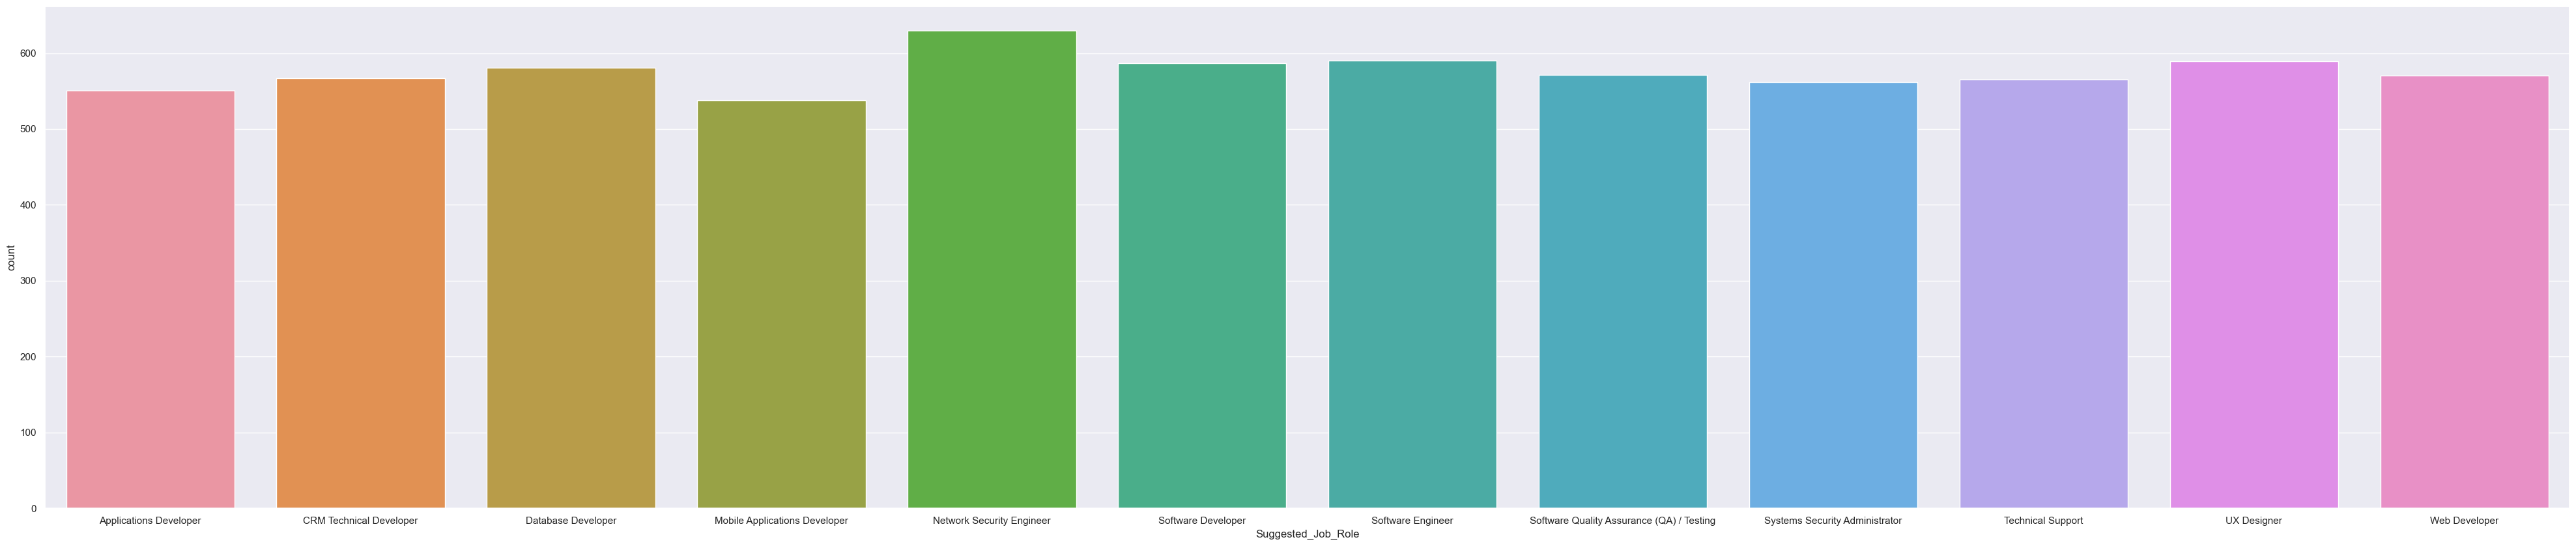

In [38]:
# Checking for data imbalanceness if any
sns.set(rc={'figure.figsize':(50,10)})
sns.countplot(x = df["Suggested_Job_Role"])

In [62]:
X = df.drop(columns=["Suggested_Job_Role"],axis=1)
y = df["Suggested_Job_Role"]
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# y = label_encoder.transform(y)
# pd.DataFrame(y).value_counts()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [40]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[19 15 15 14  9 10 22 16 10 22 11 17]
 [ 9 15  8  9 14 16 18 14 11 13 12 15]
 [ 7 15 18  7 17 16 17 13 16 12 10 15]
 [13  7 18 18  9 16 16 14 12 19 15 15]
 [16 11 16  8 29 17 13 14 20 19 17 13]
 [12 14 13 17 16 15 13 12 13 16 14 15]
 [18 16 14 15 16 19 10 20 17 22 13 17]
 [13 14 14 16 14 18 12 16 12 15 11  8]
 [10  6 18 13 16 15 18 18 13 20 14 11]
 [14 15 15 14 10 11 11 14 16 15 15 12]
 [ 8 16  9 16 16 14 27 17 15 12 20 12]
 [11 18 12 15  8 21 13 16 15 11 16  7]]
  
accuracy= 9.415741187831966


In [41]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()

In [42]:
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[12 10 22 12 20 10 13 22 15 21 12 11]
 [ 3 10 16  9 24  9 15 13 11 20 16  8]
 [ 8 18 22 10 28 12  8 13 11 13  8 12]
 [10 12 21 11 25 12 13 12 11 15 18 12]
 [ 7 19 21  6 20 20 17 13 16 16 23 15]
 [ 5 15 14  7 26 16 12 13 21 20 10 11]
 [11 22 18 12 12 14 21 14 21 22 14 16]
 [ 5 18 17  5 24 23 16 14  5 12  9 15]
 [ 3 17 29  7 17 21 13 10 16 20  6 13]
 [ 3 12 26  5 21 13 10 10 17 16 12 17]
 [10 14 10 15 23 22 18 10 10 24 12 14]
 [ 8 16 18 10 17  9 10 16 14 17 13 15]]
  
accuracy= 8.932882665379044


In [43]:
svm_model = svm.SVC(kernel="rbf")
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_cm = confusion_matrix(y_test,svm_predictions)
svm_accuracy = accuracy_score(y_test,svm_predictions)
print("confusion matrics=\n",svm_cm)
print("  ")
print("accuracy=",svm_accuracy*100)

confusion matrics=
 [[ 1  7 16  2 55 46  8  9  5 14 15  2]
 [ 1  7 16  2 49 25  5  5  2 24 14  4]
 [ 0 11 22  0 58 27  5  2  6 19 11  2]
 [ 1  6 21  1 48 33  7  1  8 23 20  3]
 [ 0 15 23  1 53 40  7  6  6 19 18  5]
 [ 1 13  8  2 46 48 12  1  4 18 14  3]
 [ 1 28 19  2 53 39  7  3  0 27 17  1]
 [ 1 20 20  2 35 44  5  1  0 17 14  4]
 [ 0 20 16  0 44 47  8  1  2 24  9  1]
 [ 0 13 19  0 42 26  7  2  5 29 15  4]
 [ 1  7 14  3 63 38 11  0  3 19 19  4]
 [ 0 17 17  0 50 37  5  2  1 22  8  4]]
  
accuracy= 9.367455335586673


In [44]:
random_forest_model = RandomForestClassifier(random_state=0)
random_forest_model.fit(X_train, y_train)
random_forest_predictions = random_forest_model.predict(X_test)
rfc_cm = confusion_matrix(y_test,random_forest_predictions)
rfc_accuracy = accuracy_score(y_test,random_forest_predictions)
print("confusion matrics=\n",rfc_cm)
print("  ")
print("accuracy=",rfc_accuracy*100)

confusion matrics=
 [[10 23 16  9 31 15  9 16  7 22 13  9]
 [15 13 13  5 23 18 14 14 11  9  9 10]
 [13 17 15 10 19  8 15 15 14 14 10 13]
 [13 10 23 12 21 16 10 18  9 12 14 14]
 [ 9 19 18 11 22 26 15 15 13 15 14 16]
 [13 24 17 12 13 16 14 14 13 12  7 15]
 [10 15 14  9 31 28 13 19 15 15 16 12]
 [11 15 22  9 14 21 11 16  2 13 15 14]
 [ 9 22 23 11 22 17  7 17 14 10 11  9]
 [ 8 11 19 14 22 16  9 18 10 13 12 10]
 [12 10 18  7 21 17 18 19 19 19  7 15]
 [11 13 19  7 17 20 15 16  9 14 14  8]]
  
accuracy= 7.677450507001449


In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=100,learning_rate= 0.02, random_state=0,algorithm="SAMME")
adaboost_model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=10),
                   learning_rate=0.02, n_estimators=100, random_state=0)

In [46]:
from sklearn.metrics import classification_report

adaboost_predictions = adaboost_model.predict(X_test)
print(classification_report(y_test,adaboost_predictions))
print(accuracy_score(y_test,adaboost_predictions)*100)

              precision    recall  f1-score   support

           0       0.10      0.06      0.07       180
           1       0.06      0.08      0.07       154
           2       0.08      0.09      0.08       163
           3       0.04      0.02      0.03       172
           4       0.09      0.08      0.08       193
           5       0.10      0.14      0.12       170
           6       0.08      0.06      0.07       197
           7       0.06      0.08      0.07       163
           8       0.09      0.07      0.08       172
           9       0.06      0.09      0.08       162
          10       0.12      0.14      0.13       182
          11       0.08      0.07      0.07       163

    accuracy                           0.08      2071
   macro avg       0.08      0.08      0.08      2071
weighted avg       0.08      0.08      0.08      2071

8.112023177209078


In [47]:
from sklearn.naive_bayes import GaussianNB

gaussian_nb_model = GaussianNB().fit(X_train, y_train)

# accuracy on X_test
accuracy = gaussian_nb_model.score(X_test, y_test)
accuracy

0.08932882665379044

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=2, max_depth=2, random_state=0)
gradient_boosting_model.fit(X_train, y_train)
gradient_boosting_predictions = gradient_boosting_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, gradient_boosting_predictions))

print("Classification Report")
print(classification_report(y_test, gradient_boosting_predictions))

accuracy = gradient_boosting_model.score(X_test, y_test)
print(accuracy*100)

Confusion Matrix:
[[ 0 13 34  1 64 23  6  7  2  9  7 14]
 [ 0  9 18  5 51 14  6  9  2 12 14 14]
 [ 0  9 22  0 65 21  2  8  5  8 12 11]
 [ 0 14 22  0 66 17 10  7  0  8 15 13]
 [ 0 16 26  1 70 26  6  7  4  6 15 16]
 [ 0  9 18  1 79 19  3  7  5  8 11 10]
 [ 0 12 26  0 61 29  1  9  8 11 23 17]
 [ 0  8 24  1 62 17  2  9  4  8 10 18]
 [ 1 12 30  1 52 27  3  7  6  9 15  9]
 [ 0  9 28  0 56 21  2 11  4 12  9 10]
 [ 0  9 22  0 69 28  4  8  4 13 11 14]
 [ 1 14 21  1 54 26  2 14  3  5 12 10]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.07      0.06      0.06       154
           2       0.08      0.13      0.10       163
           3       0.00      0.00      0.00       172
           4       0.09      0.36      0.15       193
           5       0.07      0.11      0.09       170
           6       0.02      0.01      0.01       197
           7       0.09      0.06      0.07       163
    

In [49]:
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,36,2):
    knn_classifier = KNeighborsClassifier(n_neighbors = i,weights ="distance")
    knn_classifier.fit(X_train, y_train)
    knn_classifier_predictions = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test,knn_classifier_predictions)
    print("K: ",i,"Accuracy: ",accuracy)

K:  1 Accuracy:  0.09174311926605505
K:  3 Accuracy:  0.09270883631096088
K:  5 Accuracy:  0.08498309995171414
K:  7 Accuracy:  0.07967165620473202
K:  9 Accuracy:  0.08015451472718493
K:  11 Accuracy:  0.08450024142926123
K:  13 Accuracy:  0.08063737324963785
K:  15 Accuracy:  0.07436021245774987
K:  17 Accuracy:  0.0816030902945437
K:  19 Accuracy:  0.09415741187831965
K:  21 Accuracy:  0.08739739256397876
K:  23 Accuracy:  0.09367455335586673
K:  25 Accuracy:  0.09319169483341382
K:  27 Accuracy:  0.09464027040077258
K:  29 Accuracy:  0.08932882665379044
K:  31 Accuracy:  0.09270883631096088
K:  33 Accuracy:  0.08932882665379044
K:  35 Accuracy:  0.08884596813133752


In [50]:
df.head()

,Logical_Quotient_Rating,Hackathons,Coding_Skills_Rating,Public_Speaking_Points,Self_Learning_Capability,Extra_Courses_Did,Reading_And_Writing_Skills,Memory_Capability_Score,Taken_Inputs_From_Seniors_Or-Elders,Management_Or_Technical,...,dum_r programming,dum_shell programming,dum_cloud computing,dum_data science,dum_database security,dum_game development,dum_hacking,dum_system designing,dum_testing,dum_web technologies
0,5,0,6,2,1,0,2,2,0,0,...,0,0,0,0,0,0,0,0,1,0
1,7,6,4,3,0,1,0,1,1,1,...,0,1,0,0,0,0,0,0,1,0
2,2,3,9,1,0,1,0,2,1,1,...,0,0,0,0,0,0,0,0,1,0
3,2,6,3,5,0,1,0,2,1,0,...,1,0,0,0,1,0,0,0,0,0
4,2,0,3,4,1,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [70]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=100,random_state=0,algorithm="SAMME")
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [20,50, 100]
grid['learning_rate'] = [0.01,0.02, 0.05, 0.1]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, random_state=0)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean*100, stdev, param))

Best: 0.083510 using {'learning_rate': 0.1, 'n_estimators': 20}
8.156830 (0.008039) with: {'learning_rate': 0.01, 'n_estimators': 20}
8.248116 (0.007872) with: {'learning_rate': 0.01, 'n_estimators': 50}
8.261129 (0.007122) with: {'learning_rate': 0.01, 'n_estimators': 100}
8.251006 (0.007659) with: {'learning_rate': 0.02, 'n_estimators': 20}
8.279982 (0.007376) with: {'learning_rate': 0.02, 'n_estimators': 50}
8.143767 (0.006846) with: {'learning_rate': 0.02, 'n_estimators': 100}
8.055398 (0.007797) with: {'learning_rate': 0.05, 'n_estimators': 20}
8.200327 (0.007510) with: {'learning_rate': 0.05, 'n_estimators': 50}
8.072808 (0.007649) with: {'learning_rate': 0.05, 'n_estimators': 100}
8.350999 (0.007179) with: {'learning_rate': 0.1, 'n_estimators': 20}
8.168411 (0.006686) with: {'learning_rate': 0.1, 'n_estimators': 50}
8.239376 (0.005060) with: {'learning_rate': 0.1, 'n_estimators': 100}


In [72]:
adaboost_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=20, learning_rate=0.1,
                                    random_state=0, algorithm="SAMME")
adaboost_model.fit(X_train, y_train)
from sklearn.metrics import classification_report

adaboost_predictions = adaboost_model.predict(X_test)
print(classification_report(y_test, adaboost_predictions))
print(accuracy_score(y_test, adaboost_predictions) * 100)

                                           precision    recall  f1-score   support

                   Applications Developer       0.12      0.08      0.10       180
                  CRM Technical Developer       0.06      0.10      0.08       154
                       Database Developer       0.08      0.09      0.08       163
            Mobile Applications Developer       0.12      0.08      0.10       172
                Network Security Engineer       0.10      0.11      0.11       193
                       Software Developer       0.11      0.15      0.13       170
                        Software Engineer       0.07      0.04      0.05       197
Software Quality Assurance (QA) / Testing       0.08      0.10      0.09       163
           Systems Security Administrator       0.10      0.08      0.09       172
                        Technical Support       0.08      0.09      0.09       162
                              UX Designer       0.08      0.09      0.09       182
   

In [73]:
final_adaboost_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=100, learning_rate=0.02,
                                    random_state=0, algorithm="SAMME")
final_adaboost_model.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=10),
                   learning_rate=0.02, n_estimators=100, random_state=0)

In [74]:
import pickle
pickle.dump(final_adaboost_model, open("adaboost_final_model.pkl", 'wb'))